# Распознавание текста при помощи библиотеки

Импорт библиотек

In [ ]:
!sudo apt install tesseract-ocr
!sudo apt install tesseract-ocr-rus
!sudo apt install pytesseract

In [ ]:
import requests
import glob
import re
import pytesseract
import cv2
from urllib.parse import urlencode
from zipfile import ZipFile
import zipfile

Загрузка архива с яндекс диска

In [ ]:
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
public_key = 'https://disk.yandex.ru/d/kVdTaY8TuGvBkw' 

In [ ]:
final_url = base_url + urlencode(dict(public_key=public_key))
response = requests.get(final_url)
download_url = response.json()['href']

In [ ]:
download_response = requests.get(download_url)
with open('downloaded_file.zip', 'wb') as f:  
    f.write(download_response.content)

Распаковка архива

In [ ]:
archive = 'downloaded_file.zip'
zip_file = ZipFile(archive)
with zipfile.ZipFile(archive, 'r') as zip_file:
    zip_file.extractall()

Чтение текста с фотографий при помощи tesseract

In [ ]:
data = ''
config = r'--oem 3 --pcm 6'
for img in glob.glob('/content/ DataForOCR/*.*'):
        image = cv2.imread(img)
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        string = pytesseract.image_to_string(gray, lang='rus', config=config)
        data += string

In [ ]:
text = re.sub('[^А-Я\s]+', '', data)
text.replace('\n', '').replace('\x0c', '')

'                           АРА ИЯ      ОТДЕЛОМ  И РП    ПО СВЕРДЛО ОБ  В КИРОВСКОМ РНЕ РИНЕ Д              АНАТОЛЬЕВНА     СК ФЕДЕРАЦИЯПАСПОРТНОВИЗОВЫМ ОТДЕЛЕНИЕМОВД ПРЕСНЕНСКОГО РАЙОНАУВД ЦАО ГОРОДА МОСКВЫ   ТРАМПДОНАЛЬДГОР КУИНСШТАТ НЬЮЙОРК   ОТДЕЛА УФСРОССИИПЕТЕРБУРГУ И ЛЕНИНГРАДСКОЙ ОБЛВ МОСКОВСКОМ РНЕ ГОРСАНКТ ПЕТЕРБУРГА  ФЕЛЕРАНИЯОТДЕЛОМ ВНУТРЕННИХ ДЕЛОКТЯБРЬСКОГО ОКРУГА  ГОРОДА АРХАНГЕЛЬСКА  П А                                            ИМЯРЕК  ЕВГЕНИЙ АЛЕКСАНДРОВИЧ МУЖ     ГОР АРХАНГЕЛЬСК  П ФЕЛЕРЕНИЯОТДЕЛОМ УФМС РОССИИ ПОСАМАРСКОЙ ОБЛАСТИ В ЦЕНТРАЛЬНОМРАЙОНЕ ГОРОДА ТОЛЬЯТТИ     Л       ФИО  МУЖМАЛЕКСЕЕВИЧ  ГОР САМАРА Т ТЕ РАТИ ИЕ       И    В    И НУВОЧИИУЕ У  Ш  КУЗЕВАНОВИГОРЕВИЧВ ГОРОДЕ ГЛАЗОВЕ УФМС РОССИИПО ПЕРМСКОМУ КРАЮ  ФЕАКРАЦИЯ РОВД ИТИНО РМОСКВЫ Е     ВАСЛЕВСКИЙ     ГРИГОРИЙ ПЕТРОВИЧ МУХ    СИДРИНСКОЕКРАСНОЯРСКОГО КРАЯ     РОССИЙСКАЯ ФЕДЕРАЦИЯОТДЕЛОМ ВНУТРЕННИХ ДЕЛГОР КРАСНОЗНАМЕНСК ШАПОШНИКОВА ВИКТОРИЯНИКОЛАЕВНАКРАСНОЗНАМЕНСКП  П РФ С   Е Б         Я АРТЖ ОТДЕЛЕНИЕ

# Распознавание текста при помощи нейронной сети

Импорт библиотек

In [ ]:
!pip install split-folders

In [ ]:
import os
import numpy as np
import tensorflow as tf
import splitfolders
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras import utils
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing import image_dataset_from_directory
import matplotlib.pyplot as plt
from google.colab import files
from typing import *
from PIL import Image
from pathlib import Path
from google.colab.patches import cv2_imshow
%matplotlib inline 

Функция преобразования картинок

In [ ]:
def make_background(img):
    image=img
    file_without_extension = image.split('.')[0]
    image = cv2.imread(image, cv2.IMREAD_UNCHANGED)
    trans_mask = image[:, :, 3] == 0
    image[trans_mask] = [255, 255, 255, 255]
    new_img = cv2.cvtColor(image, cv2.COLOR_BGRA2GRAY)
    size = cv2.resize(new_img, (28, 28))
    cv2.imwrite(file_without_extension + '.jpeg', size)
    os.remove(img)

Загрузка Dataset'а

In [ ]:
!git clone https://github.com/GregVial/CoMNIST.git

In [ ]:
!unzip /content/CoMNIST/images/Cyrillic.zip

In [ ]:
!rm -rf /content/Cyrillic/I

In [ ]:
for img in glob.glob('/content/Cyrillic/*/*.png'):
    make_background(img)

In [ ]:
splitfolders.ratio('/content/Cyrillic', '/content/Cyrillic-split', ratio=(0.7, 0.2, 0.1), seed=2, group_prefix=None)

Copying files: 15233 files [00:01, 7919.36 files/s]


Создаем Tensorflow Dataset'ы

In [ ]:
batch_size=256
image_size=(28, 28)

Наборы данных для обучения и проверки

In [ ]:
train_dataset = image_dataset_from_directory('/content/Cyrillic-split/train/',                                             
                                             seed=42,
                                             color_mode='grayscale',                                            
                                             batch_size=batch_size,
                                             image_size=image_size)

validation_dataset = image_dataset_from_directory('/content/Cyrillic-split/val/',                                            
                                             seed=42,
                                             color_mode='grayscale',                                             
                                             batch_size=batch_size,
                                             image_size=image_size)

test_dataset = image_dataset_from_directory('/content/Cyrillic-split/test/',
                                             batch_size=batch_size,
                                             color_mode='grayscale',
                                             image_size=image_size)

Found 10647 files belonging to 33 classes.
Found 3032 files belonging to 33 classes.
Found 1554 files belonging to 33 classes.


Названия классов в наборе данных

In [ ]:
class_names = train_dataset.class_names
class_names

['Ё',
 'А',
 'Б',
 'В',
 'Г',
 'Д',
 'Е',
 'Ж',
 'З',
 'И',
 'Й',
 'К',
 'Л',
 'М',
 'Н',
 'О',
 'П',
 'Р',
 'С',
 'Т',
 'У',
 'Ф',
 'Х',
 'Ц',
 'Ч',
 'Ш',
 'Щ',
 'Ъ',
 'Ы',
 'Ь',
 'Э',
 'Ю',
 'Я']

Примеры изображений

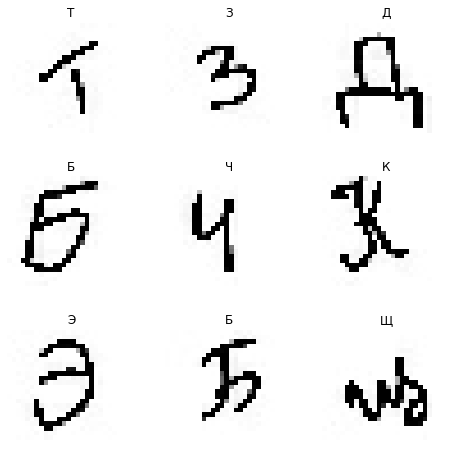

In [ ]:
plt.figure(figsize=(8, 8))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().reshape(28, 28), cmap='gray')
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
emnist_labels = test_dataset.class_names

Настраиваем производительность TensorFlow DataSet'ов

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

Создаем нейронную сеть

In [ ]:
model = Sequential()

model.add(Conv2D(16, (5, 5), padding='same', 
                 input_shape=(28, 28, 1), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, (5, 5), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (5, 5), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (5, 5), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(33, activation='softmax'))

Компилируем модель

In [ ]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

Обучаем нейронную сеть

In [ ]:
history = model.fit(train_dataset, 
                    validation_data=validation_dataset,
                    epochs=10,
                    verbose=2)

Epoch 1/10
42/42 - 18s - loss: 0.1862 - accuracy: 0.9389 - val_loss: 0.4361 - val_accuracy: 0.8799 - 18s/epoch - 430ms/step
Epoch 2/10
42/42 - 18s - loss: 0.1870 - accuracy: 0.9367 - val_loss: 0.4416 - val_accuracy: 0.8648 - 18s/epoch - 420ms/step
Epoch 3/10
42/42 - 17s - loss: 0.1298 - accuracy: 0.9571 - val_loss: 0.4062 - val_accuracy: 0.8882 - 17s/epoch - 411ms/step
Epoch 4/10
42/42 - 17s - loss: 0.1007 - accuracy: 0.9661 - val_loss: 0.4278 - val_accuracy: 0.8882 - 17s/epoch - 411ms/step
Epoch 5/10
42/42 - 17s - loss: 0.0795 - accuracy: 0.9732 - val_loss: 0.4815 - val_accuracy: 0.8813 - 17s/epoch - 411ms/step
Epoch 6/10
42/42 - 17s - loss: 0.0705 - accuracy: 0.9770 - val_loss: 0.4815 - val_accuracy: 0.8836 - 17s/epoch - 409ms/step
Epoch 7/10
42/42 - 17s - loss: 0.0737 - accuracy: 0.9751 - val_loss: 0.4510 - val_accuracy: 0.8882 - 17s/epoch - 411ms/step
Epoch 8/10
42/42 - 17s - loss: 0.0733 - accuracy: 0.9742 - val_loss: 0.4845 - val_accuracy: 0.8892 - 17s/epoch - 412ms/step
Epoch 9/

Оцениваем качетсво обучения сети

In [ ]:
scores = model.evaluate(test_dataset, verbose=1)

7/7 [==============================] - 1s 76ms/step - loss: 0.4556 - accuracy: 0.9003


In [ ]:
print("Доля верных ответов на тестовых данных, в процентах:", round(scores[1] * 100, 4))

Доля верных ответов на тестовых данных, в процентах: 90.0257


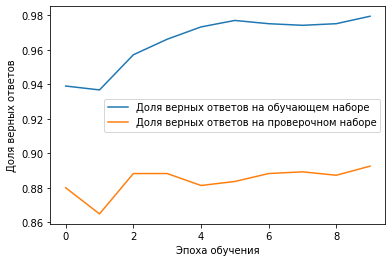

In [ ]:
plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

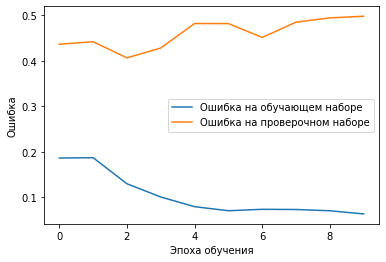

In [ ]:
plt.plot(history.history['loss'], 
         label='Ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Ошибка на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Ошибка')
plt.legend()
plt.show()

Сохраняем обученную нейронную сеть

In [ ]:
model.save("Cyrillic.h5")

Распознавание паспортов нейронной сетью

In [ ]:
model = keras.models.load_model('/content/Cyrillic.h5')

In [ ]:
def emnist_predict_img(model, img):
    img_arr = np.expand_dims(img, axis=0)
    img_arr = 1 - img_arr/255.0
    img_arr = img_arr.reshape((1, 28, 28, 1))

    predict = model.predict([img_arr])
    result = np.argmax(predict, axis=1)
    return (emnist_labels[result[0]])


def letters_extract(image_file: str, out_size=28) -> List[Any]:
    img = cv2.imread(image_file)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    dst = cv2.fastNlMeansDenoising(gray, 10, 10, 7, 21)
    ret, thresh = cv2.threshold(dst, 170, 255, cv2.THRESH_BINARY)
    img_erode = cv2.erode(thresh, np.ones((2, 2), np.uint8), iterations=1)
    
    contours, hierarchy = cv2.findContours(img_erode, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    output = img.copy()

    letters = []
    for idx, contour in enumerate(contours):
        (x, y, w, h) = cv2.boundingRect(contour)        
        if hierarchy[0][idx][3] == 0:
            cv2.rectangle(output, (x, y), (x + w, y + h), (70, 0, 0), 1)
            letter_crop = gray[y:y + h, x:x + w]
            print(letter_crop.shape)
            
            size_max = max(w, h)
            letter_square = 255 * np.ones(shape=[size_max, size_max], dtype=np.uint8)
            if w > h:                
                y_pos = size_max//2 - h//2
                letter_square[y_pos:y_pos + h, 0:w] = letter_crop
            elif w < h:                
                x_pos = size_max//2 - w//2
                letter_square[0:h, x_pos:x_pos + w] = letter_crop
            else:
                letter_square = letter_crop
            
            letters.append((x, w, cv2.resize(letter_square, (out_size, out_size), interpolation=cv2.INTER_AREA)))
    
    letters.sort(key=lambda x: x[0], reverse=False)

    cv2_imshow(img)
    cv2_imshow(thresh)
    cv2_imshow(img_erode)
    cv2_imshow(output)
    #cv2_imshow(letters[0][2])
    #cv2_imshow(letters[1][2])
    #cv2_imshow(letters[2][2])
    #cv2_imshow(letters[3][2])
    #cv2_imshow(letters[4][2])
    return letters


def img_to_str(model: Any, image_file: str):
    letters = letters_extract(image_file)
    s_out = ""
    for i in range(len(letters)):
        dn = letters[i+1][0] - letters[i][0] - letters[i][1] if i < len(letters) - 1 else 0
        s_out += emnist_predict_img(model, letters[i][2])
        if (dn > letters[i][1]/4):
            s_out += ' '
    return s_out

    
    #s_out = img_to_str(model, '/content/ DataForOCR/1.jpeg')
    #print(s_out)

In [ ]:
data = ''
for img in glob.glob('/content/ DataForOCR/*.*'):
    string = img_to_str(model, img)
    data += string

In [ ]:
print(data)

ПППППППППЛППППППППППППППППЛППППППППППП ПППППППППППППППППППППППППППППППППППЛПЛПППППППППППППЛППППППППППППППППППППППППППППППППППППППППППППППППППППППППППППППППППППППППППППППППППППППППППППППППППППППППППППППППППППППППППППППППППППППППППППППППППП П ППППППППППППППППППППППППППППЛПППППППППППППППППППППППППП ППППППППППППППППППППППППППППППППППППППППППППППППП ПППППППППППППППППППП ППППППППППППППППППППППППППППППППППППППППППППППППППППППППППППППППППППППППППППППППППППППППППППППППППППППППППППППППППППППППППППППППППППППППППППППППППППППППППППППППППППППППППППППППППППППППППППППППППППППППППППЛППППППППППППППППППППППППППППППППППППППППППППППППППППППППППППППППППППППППППП ПППППППППППППППППППППППППППППППППППППППП ППППППППППППППППППППП ПППППППППППП ПППППППППППП ПППППППППППППППППППППППППППППП ПППППППП ППП


Алгоритм работает, но настроить его, что бы он корректно распознавал текст с паспортов, не удалось